In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# Importing the Necessary Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Loading the Training Dataset

In [3]:
training_dataset = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
pd.set_option('display.max_columns', None)
training_dataset.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,PlatformType,Processor,OSVersion,OSBuildNumber,OSProductSuite,OsPlatformSubRelease,OSBuildLab,SKUEditionName,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,MDC2FormFactor,DeviceFamily,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,PrimaryDiskType,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,ChassisType,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,PowerPlatformRole,InternalBatteryNumberOfCharges,NumericOSVersion,OSArchitecture,OSBranch,OSBuildNumberOnly,OSBuildRevisionOnly,OSEdition,OSSkuFriendlyName,OSInstallType,OSInstallLanguageID,OSUILocaleID,AutoUpdateOptionsName,IsPortableOS,OSGenuineState,LicenseActivationChannel,IsFlightsDisabled,FlightRing,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,1.0,1,51,120232.0,98.0,103,windows10,x86,10.0.0.0,14393,768,rs1,14393.2214.x86fre.rs1_release_1.180402-1758,Home,1.0,0,0.0,98.0,1.0,1.0,SmallTablet,Windows.Desktop,561.0,330367.0,4.0,5.0,1850.0,15028.0,SSD,14348.0,0,1024.0,Notebook,8.0,800.0,1280.0,Slate,1.420000e+02,10.0.14393.2214,x86,rs1_release,14393,2214,Core,CORE,Update,5.0,26,UNKNOWN,0,IS_GENUINE,Retail,0.0,Retail,513.0,21964.0,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,1.0,1,141,112854.0,167.0,227,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,0.0,137.0,1.0,1.0,AllInOne,Windows.Desktop,2668.0,25212.0,4.0,5.0,2407.0,953869.0,HDD,952592.0,1,4096.0,AllinOne,19.4,1600.0,900.0,Desktop,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,9.0,34,FullAuto,0,IS_GENUINE,OEM:DM,0.0,Retail,628.0,44548.0,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,1.0,1,51,41759.0,98.0,103,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,0.0,137.0,1.0,1.0,Desktop,Windows.Desktop,3035.0,263666.0,4.0,5.0,2719.0,228936.0,SSD,228321.0,1,8192.0,Desktop,24.0,1920.0,1080.0,Desktop,4.294967e+09,10.0.17134.285,amd64,rs4_release,17134,285,Core,CORE,Reset,5.0,26,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.0,Retail,142.0,9414.0,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,1.0,1,68,19507.0,276.0,74,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,0.0,108.0,1.0,1.0,Notebook,Windows.Desktop,2102.0,242491.0,4.0,5.0,3410.0,1907729.0,HDD,1890776.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,0.000000e+00,10.0.15063.850,amd64,rs2_release,15063,850,Core,CORE,Upgrade,7.0,30,UNKNOWN,0,IS_GENUINE,OEM:DM,0.0,Retail,554.0,33060.0,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,1.0,1,43,117801.0,53.0,42,windows10,x86,10.0.0.0,17134,256,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,1.0,0,0.0,137.0,1.0,1.0,Desktop,Windows.Desktop,2668.0,257309.0,2.0,5.0,4322.0,305245.0,HDD,52804.0,0,2048.0,Desktop,20.0,1600.0,900.0,Desktop,4.294967e+09,10.0.17134.285,x86,rs4_release,17134,285,Professional,PROFESSIONAL,UUPUpgrade,37.0,158,FullAuto,0,IS_GENUINE,Retail,0.0,Retail,628.0

In [4]:
def load_dataset():
    training_dataset = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
    return training_dataset

def load_data(train_df, test_path, submission_path):
    test_df = pd.read_csv(test_path)
    submission_df = pd.read_csv(submission_path)
    return train_df.copy(), test_df, submission_df

def display_initial_info(training_dataset):
    print("\nDataset Shape:", training_dataset.shape)
    numerical_cols = training_dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = training_dataset.select_dtypes(include=['object']).columns.tolist()
    numerical_df = pd.DataFrame({'Numerical Columns': numerical_cols + [''] * (len(categorical_cols) - len(numerical_cols))})
    categorical_df = pd.DataFrame({'Categorical Columns': categorical_cols + [''] * (len(numerical_cols) - len(categorical_cols))})
    print("\nFeature Types:")
    print(pd.concat([numerical_df, categorical_df], axis=1))
    return training_dataset

training_dataset =display_initial_info(training_dataset)


Dataset Shape: (100000, 76)

Feature Types:
                     Numerical Columns       Categorical Columns
0                           IsBetaUser                 MachineID
1              RealTimeProtectionState               ProductName
2                 IsPassiveModeEnabled             EngineVersion
3                    AntivirusConfigID                AppVersion
4        NumAntivirusProductsInstalled          SignatureVersion
5          NumAntivirusProductsEnabled              PlatformType
6                               HasTpm                 Processor
7                            CountryID                 OSVersion
8                               CityID      OsPlatformSubRelease
9                          GeoRegionID                OSBuildLab
10                 LocaleEnglishNameID            SKUEditionName
11                       OSBuildNumber            MDC2FormFactor
12                      OSProductSuite              DeviceFamily
13                   IsSystemProtected       

# Is Dataset Balanced?

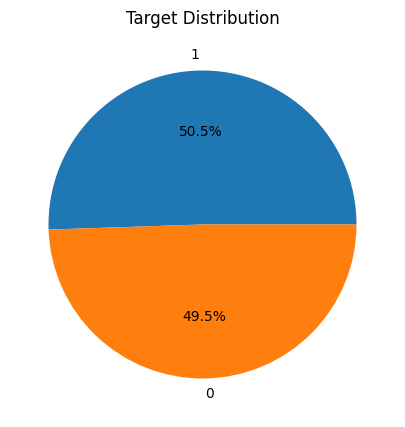

In [5]:
import matplotlib.pyplot as plt

def plot_target_distribution(training_dataset):
    plt.figure(figsize=(8, 5))
    target_dist = training_dataset['target'].value_counts()
    plt.pie(target_dist, labels=target_dist.index, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
    plt.title('Target Distribution')
    plt.show()

plot_target_distribution(training_dataset)


### Yes, the target variable is balanced, as the distribution is nearly equal between the two classes.

# Exploratory Data Analysis

## General Distribution Analysis

In [6]:
def count_unique_values(series):
    unique_values = set()
    for value in series.dropna():  # Ignore NaN values
        if value not in unique_values:
            unique_values.add(value)
            if len(unique_values) > 1:
                return False
    return True

redundant_columns = [col for col in training_dataset.columns if count_unique_values(training_dataset[col])]
print("Columns with only one unique value:", redundant_columns)

Columns with only one unique value: ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled']


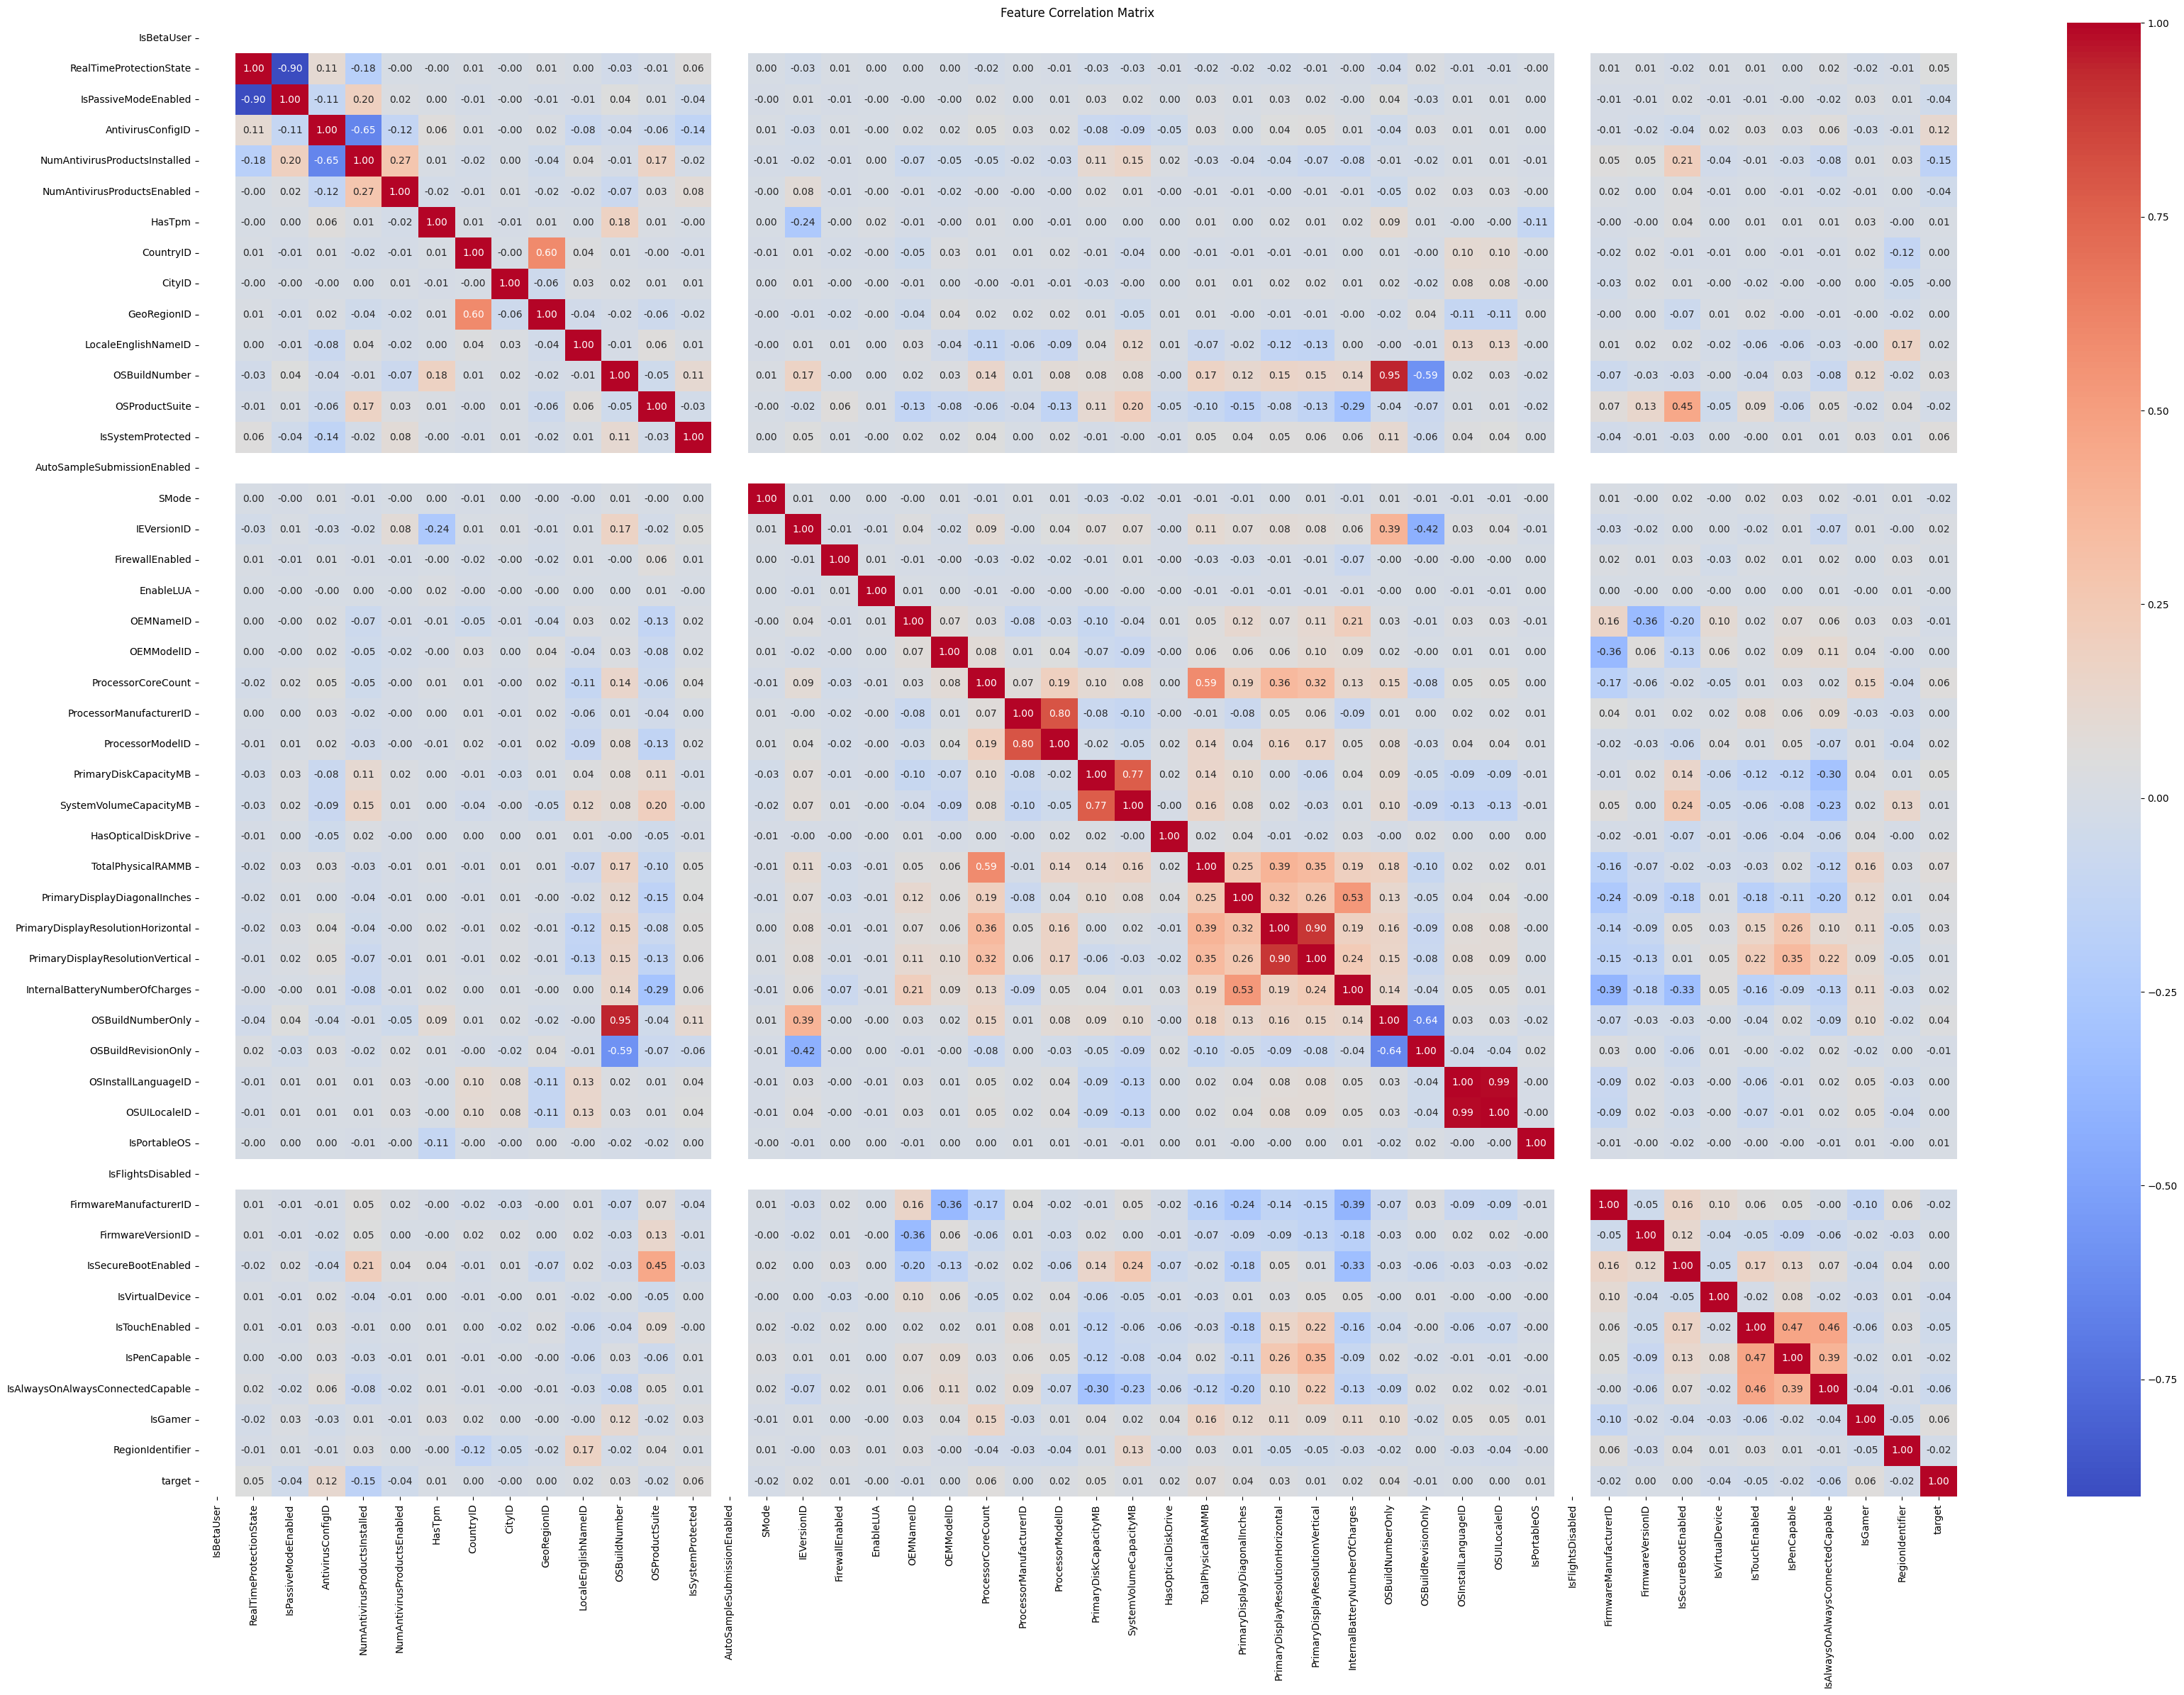

In [7]:
correlation = training_dataset.select_dtypes(include=['number']).corr()
plt.figure(figsize=(40, 27))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## Relation Between Columns

In [8]:
def plot_categorical_comparison(df, col1, col2):
    plt.figure(figsize=(14, 7))
    ax = sns.countplot(data=df, x=col1, hue=col2)
    plt.xticks(rotation=45)
    plt.title(f"{col1} vs {col2} Frequency Comparison")

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

def numerical_comparison(df, col1, col2):
    summary = df[[col1, col2]].describe()
    print(summary)

def plot_scatter_with_regression(df, x_feature, y_feature):
    plt.figure(figsize=(8, 5))
    sns.regplot(x=df[x_feature], y=df[y_feature], scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
    plt.title(f"Regression Plot: {x_feature} vs {y_feature}")
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

def numerical_comparison(df, col1, col2):
    summary = df[[col1, col2]].describe()
    print(summary)

def numerical_comparison(df, col1, col2):
    summary = df[[col1, col2]].describe()
    print(summary)

def plot_line_chart(df, x_feature, y_feature, group_by=None):
    df[x_feature] = pd.to_numeric(df[x_feature], errors="coerce")
    df[y_feature] = pd.to_numeric(df[y_feature], errors="coerce")
    df = df.dropna(subset=[x_feature, y_feature])  # Remove NaN values

    if df.empty:
        print(f"Skipping {x_feature} vs {y_feature} (No valid data)")
        return

    plt.figure(figsize=(10, 5))
    
    if group_by and group_by in df.columns:
        unique_groups = df[group_by].dropna().unique()
        for group in unique_groups:
            subset = df[df[group_by] == group]
            if not subset.empty:
                plt.plot(subset[x_feature], subset[y_feature], marker='o', label=f"{group_by}: {group}")
    else:
        plt.plot(df[x_feature], df[y_feature], marker='o')
    
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f"Line Chart: {y_feature} over {x_feature}")
    if group_by:
        plt.legend()
    plt.grid(True)
    plt.show()

def plot_pie_chart(df, category_feature):
    plt.figure(figsize=(8, 5))
    category_counts = df[category_feature].value_counts()
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    plt.title(f"Pie Chart: Distribution of {category_feature}")
    plt.show()

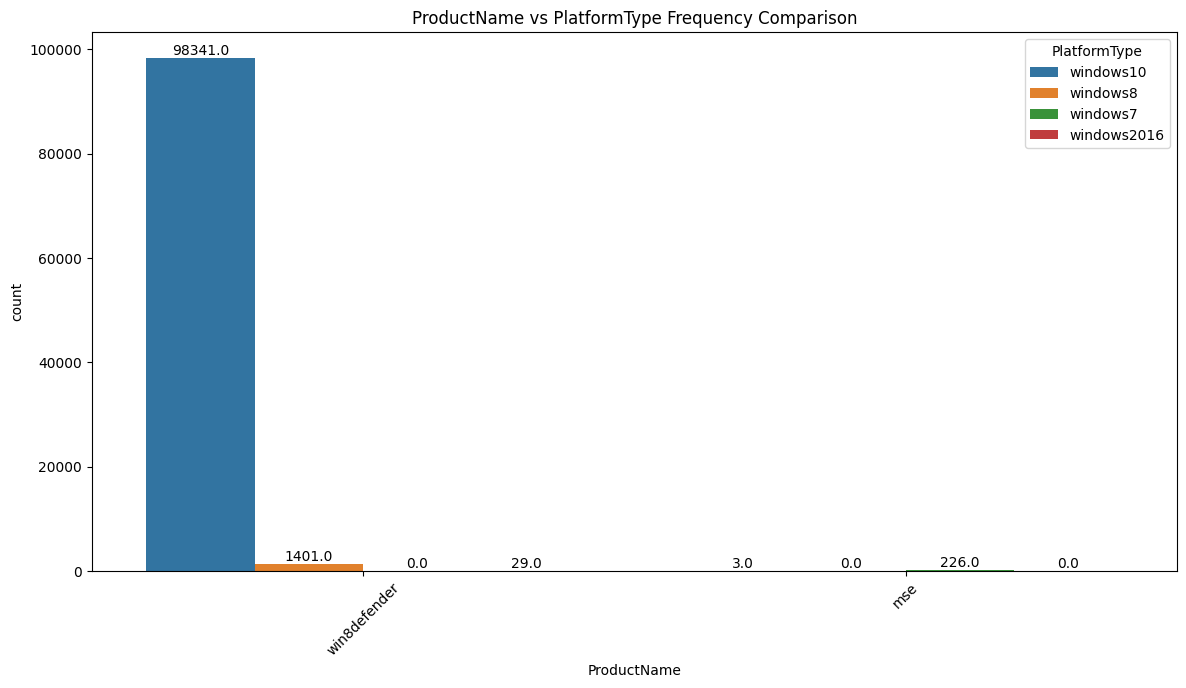

In [10]:
plot_categorical_comparison(training_dataset, "ProductName", "PlatformType")

In [12]:
'''
Observation:
The ProductName feature is highly imbalanced, with one category dominating almost the entire dataset.

Inference:
Since rare categories provide little to no predictive power, this column can be removed.
'''

'\nObservation:\nThe ProductName feature is highly imbalanced, with one category dominating almost the entire dataset.\n\nInference:\nSince rare categories provide little to no predictive power, this column can be removed.\n'

In [11]:
numerical_comparison(training_dataset, "RealTimeProtectionState", "IsPassiveModeEnabled")

       RealTimeProtectionState  IsPassiveModeEnabled
count             99934.000000         100000.000000
mean                  6.848430              0.017620
std                   1.015166              0.131566
min                   0.000000              0.000000
25%                   7.000000              0.000000
50%                   7.000000              0.000000
75%                   7.000000              0.000000
max                   8.000000              1.000000


In [ ]:
'''
Observation:
The IsPassiveModeEnabled column has a very low variance, meaning most values are concentrated in one category.
Inference:
IsPassiveModeEnabled can be removed as it likely provides minimal predictive value.
'''

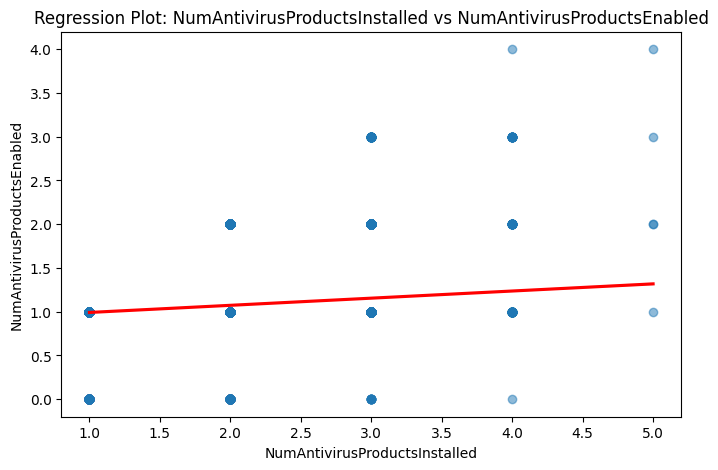

In [11]:
plot_scatter_with_regression(training_dataset, "NumAntivirusProductsInstalled", "NumAntivirusProductsEnabled")

In [ ]:
'''
Observation:
The regression plot shows no strong correlation between NumAntivirusProductsInstalled and NumAntivirusProductsEnabled.
Inference:
Both might not have a strong linear relationship, so keeping both may not significantly improve the model. Further feature engineering is needed.
'''

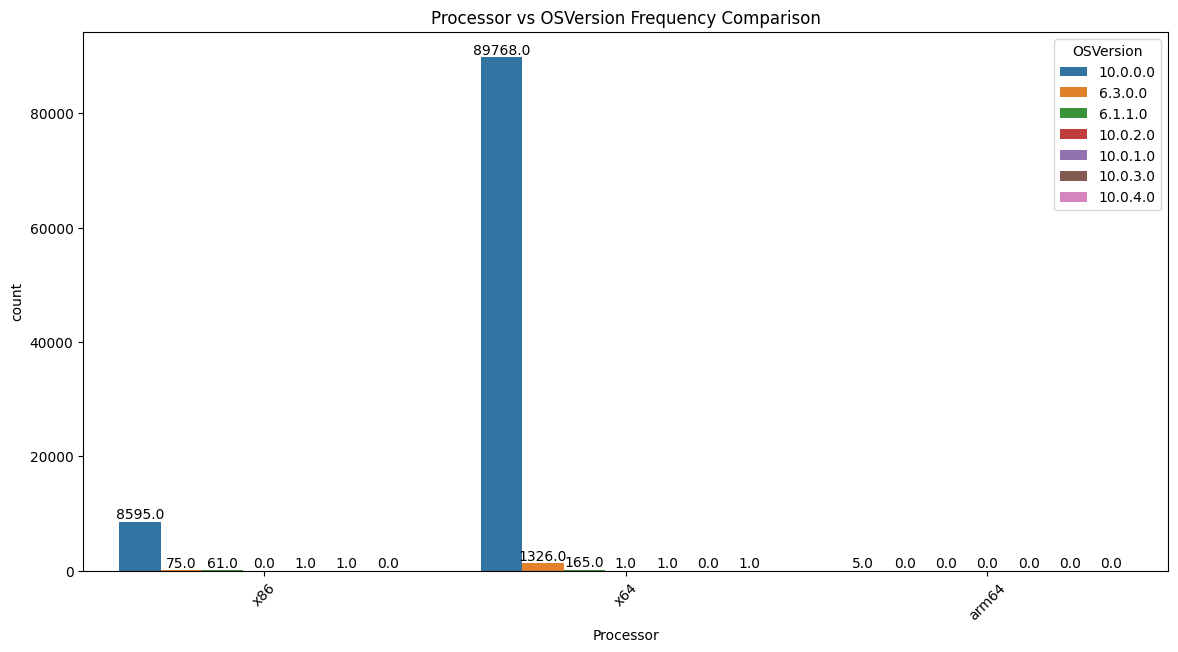

In [12]:
plot_categorical_comparison(training_dataset, "Processor", "OSVersion")

In [ ]:
'''
Observation:
The Processor feature is highly imbalanced, with almost all values concentrated in the x64 category, 
while other processor types (x86, arm64) have negligible representation.

Inference:
Since the distribution is extremely skewed, Processor may not contribute significantly to model learning. 
It can be removed or combined with other system specifications (like OSVersion) for better feature engineering.
'''

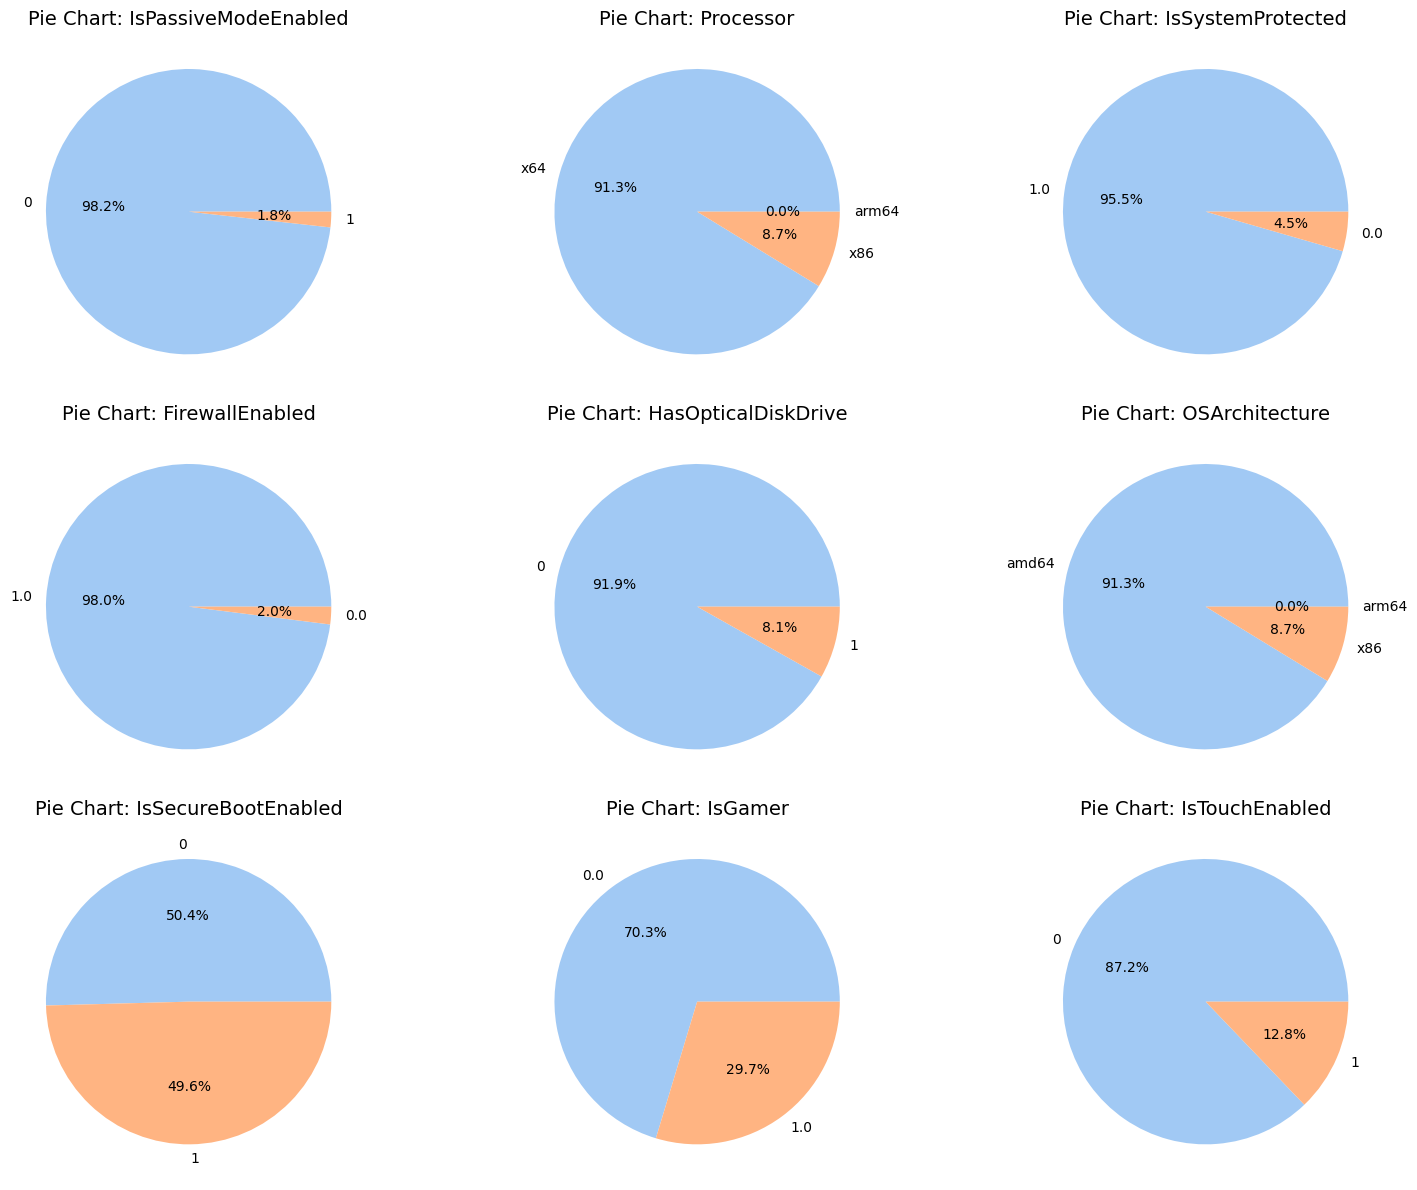

In [13]:
categorical_columns = ["IsPassiveModeEnabled", "Processor", "IsSystemProtected", "FirewallEnabled",
                       "HasOpticalDiskDrive", "OSArchitecture", "IsSecureBootEnabled", "IsGamer", "IsTouchEnabled"]

rows = (len(categorical_columns) + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(16, 12))
axes = axes.flatten()
colors = sns.color_palette("pastel") + sns.color_palette("dark")

for i, category in enumerate(categorical_columns):
    if category in training_dataset.columns:
        category_counts = training_dataset[category].value_counts()
        if not category_counts.empty:
            axes[i].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=colors[:len(category_counts)])
            axes[i].set_title(f"Pie Chart: {category}", fontsize=14)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
'''
Observation:
Several categorical features such as IsPassiveModeEnabled, IsSystemProtected, FirewallEnabled, and Processor are highly imbalanced (dominance by a single category).
Inference:
Features with extreme imbalance (like IsPassiveModeEnabled and FirewallEnabled) may not contribute meaningful information 
and can be removed or combined with other security-related features.
Processor and OSArchitecture show a similar pattern, with x64/amd64 being the dominant class, indicating low variability that might not be useful for predictive modeling.
'''

In [14]:
numerical_comparison(training_dataset, "EngineVersion", "SignatureVersion")

       EngineVersion SignatureVersion
count         100000           100000
unique            37             2735
top      1.1.15200.1     1.273.1420.0
freq           45219             1274


In [15]:
numerical_comparison(training_dataset, "NumAntivirusProductsInstalled", "NumAntivirusProductsEnabled")

       NumAntivirusProductsInstalled  NumAntivirusProductsEnabled
count                   99924.000000                 99924.000000
mean                        1.326528                     1.018264
std                         0.520681                     0.155291
min                         1.000000                     0.000000
25%                         1.000000                     1.000000
50%                         1.000000                     1.000000
75%                         2.000000                     1.000000
max                         5.000000                     4.000000


In [ ]:
'''
Observation:
The NumAntivirusProductsInstalled column has a mean of 1.32 and a maximum value of 5, 
indicating that most systems have only one or two antivirus products installed.
NumAntivirusProductsEnabled has a mean close to 1, with very low variance, suggesting that most systems have only one active antivirus.

Inference:
Since NumAntivirusProductsEnabled has very low variance, it might not provide significant predictive power and could be removed if found redundant.
'''

## Target-Based Analysis

In [16]:
def plot_kde_by_target(df, column, target_col):
    plt.figure(figsize=(8, 5))
    if df[column].dtype in ['int64', 'float64']:
        sns.kdeplot(df[df[target_col] == 0][column], label='Target 0', fill=True)
        sns.kdeplot(df[df[target_col] == 1][column], label='Target 1', fill=True)
    else:
        sns.histplot(df, x=column, hue=target_col, multiple="stack", kde=True)
    plt.title(f'Distribution of {column} by Target')
    plt.legend()
    plt.show()

def plot_categorical_vs_target(df, column, target_col):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=column, hue=target_col, palette='viridis')
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black')

    plt.xticks(rotation=45)
    plt.title(f'Distribution of {column} by Target')
    plt.show()

def plot_boxplot_by_target(df, column, target_col):
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=target_col, y=column, data=df)
    plt.title(f'Boxplot of {column} by Target')
    plt.show()

def plot_bar_categorical_vs_target(df, column, target_col):
    category_means = df.groupby(column)[target_col].mean().sort_values()
    plt.figure(figsize=(6, 3))
    category_means.plot(kind='bar', color='#4682B4')
    plt.title(f'Effect of {column} on Target')
    plt.ylabel('Mean Target Value')
    plt.xticks(rotation=45)
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


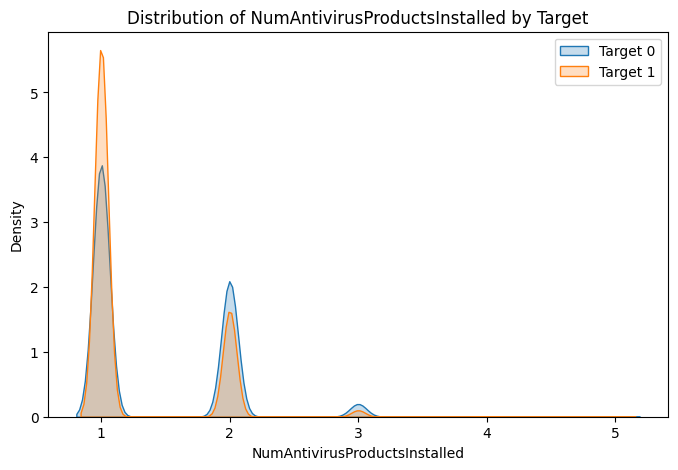

In [17]:
plot_kde_by_target(training_dataset, 'NumAntivirusProductsInstalled', 'target')  # Change column name if needed

In [111]:
# Since both classes follow a similar distribution, this feature might not be highly predictive for the target variable.

In [113]:
import scipy.stats as stats
import pandas as pd

# Separating data based on target class
group_0 = training_dataset[training_dataset['target'] == 0]['NumAntivirusProductsInstalled']
group_1 = training_dataset[training_dataset['target'] == 1]['NumAntivirusProductsInstalled']

# Performing independent t-test
t_stat, p_value_t = stats.ttest_ind(group_0, group_1, equal_var=False)

# Performing ANOVA
anova_stat, p_value_anova = stats.f_oneway(group_0, group_1)

if p_value_t < 0.05:
    print("T-test: Significant difference between the two groups (p < 0.05)")
else:
    print("T-test: No significant difference (p >= 0.05)")

if p_value_anova < 0.05:
    print("ANOVA: Significant difference between the two groups (p < 0.05)")
else:
    print("ANOVA: No significant difference (p >= 0.05)")

T-test: No significant difference (p >= 0.05)
ANOVA: No significant difference (p >= 0.05)


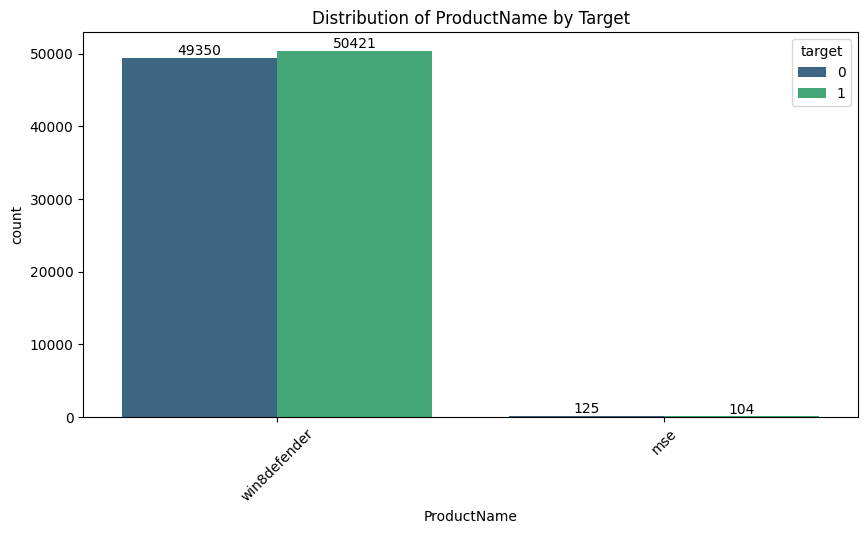

In [18]:
plot_categorical_vs_target(training_dataset, 'ProductName', 'target')

In [110]:
'''
Observation:
The majority of entries belong to "win8defender", with almost equal distribution across both target classes (0 and 1).
The other product names (e.g., "mse") appear in negligible amounts, making them insignificant in the dataset.
Inference:
Since ProductName is dominated by one category (win8defender) and does not show significant 
discrimination between target classes, it likely adds no meaningful information for prediction.
This column can be removed
'''

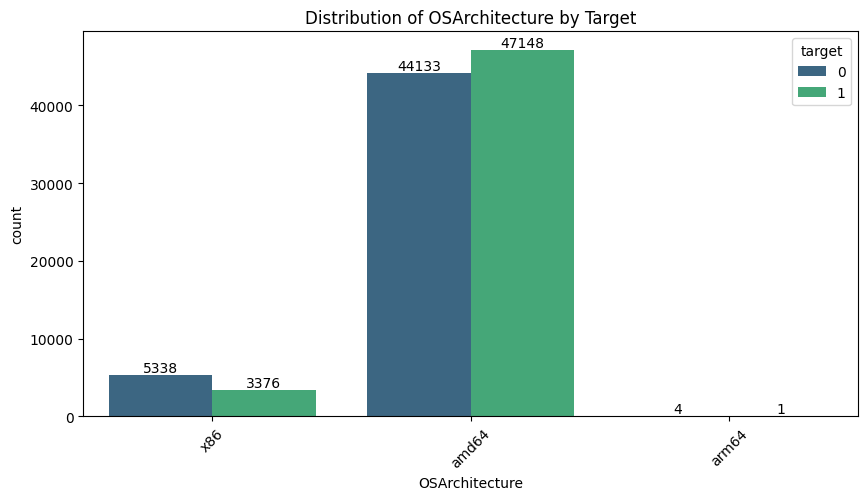

In [19]:
plot_categorical_vs_target(training_dataset, 'OSArchitecture', 'target')

In [114]:
'''
Observation:
Most devices use the "amd64" OS architecture, with nearly equal distribution across both target classes.
"x86" has a lower count but still follows a similar pattern, while "arm64" is almost negligible.
Inference:
Since OSArchitecture does not strongly differentiate between target classes, it may not be a useful predictive feature.
'''

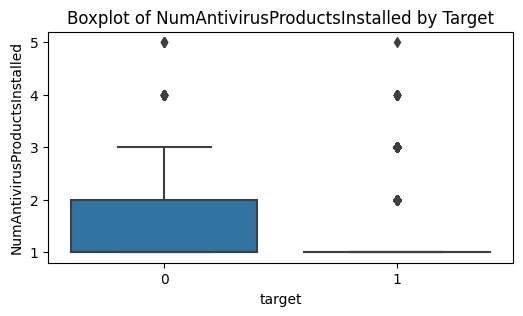

In [20]:
plot_boxplot_by_target(training_dataset, 'NumAntivirusProductsInstalled', 'target')

In [115]:
# Since both classes share similar distributions, this feature might not be a strong predictor.

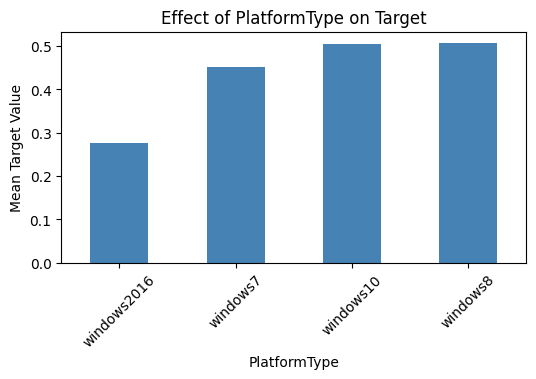

In [21]:
plot_bar_categorical_vs_target(training_dataset, 'PlatformType', 'target')

In [116]:
'''windows10 and windows8 show the highest threat levels (target=1 50%).
windows2016 has fewer threats (30%).'''

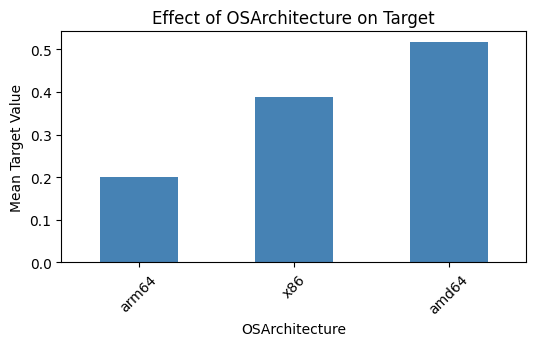

In [22]:
plot_bar_categorical_vs_target(training_dataset, 'OSArchitecture', 'target')

In [ ]:
'''amd64 systems have the highest risk (50%).
x86 architectures have a lower risk (35%).
arm64 shows minimal threat activity.'''

## Multivariate Analysis

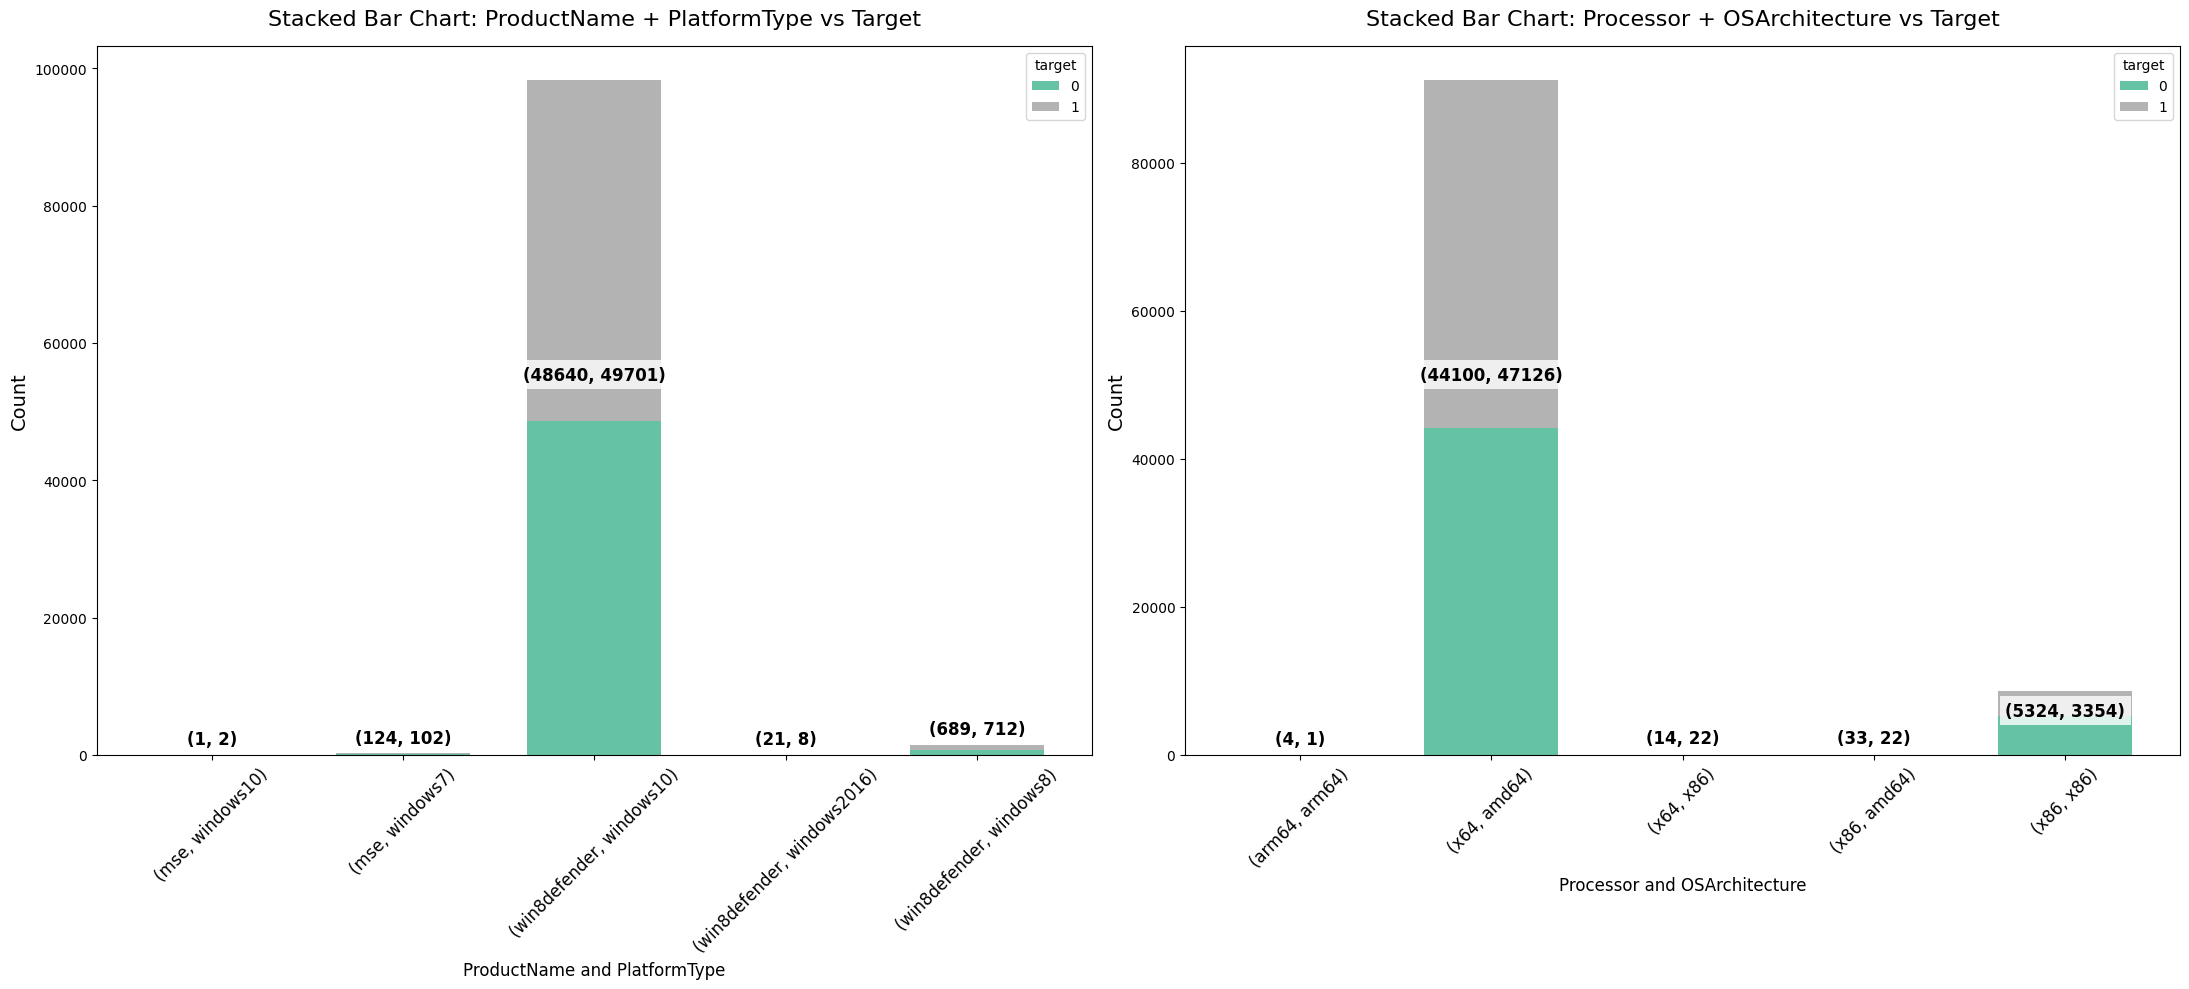

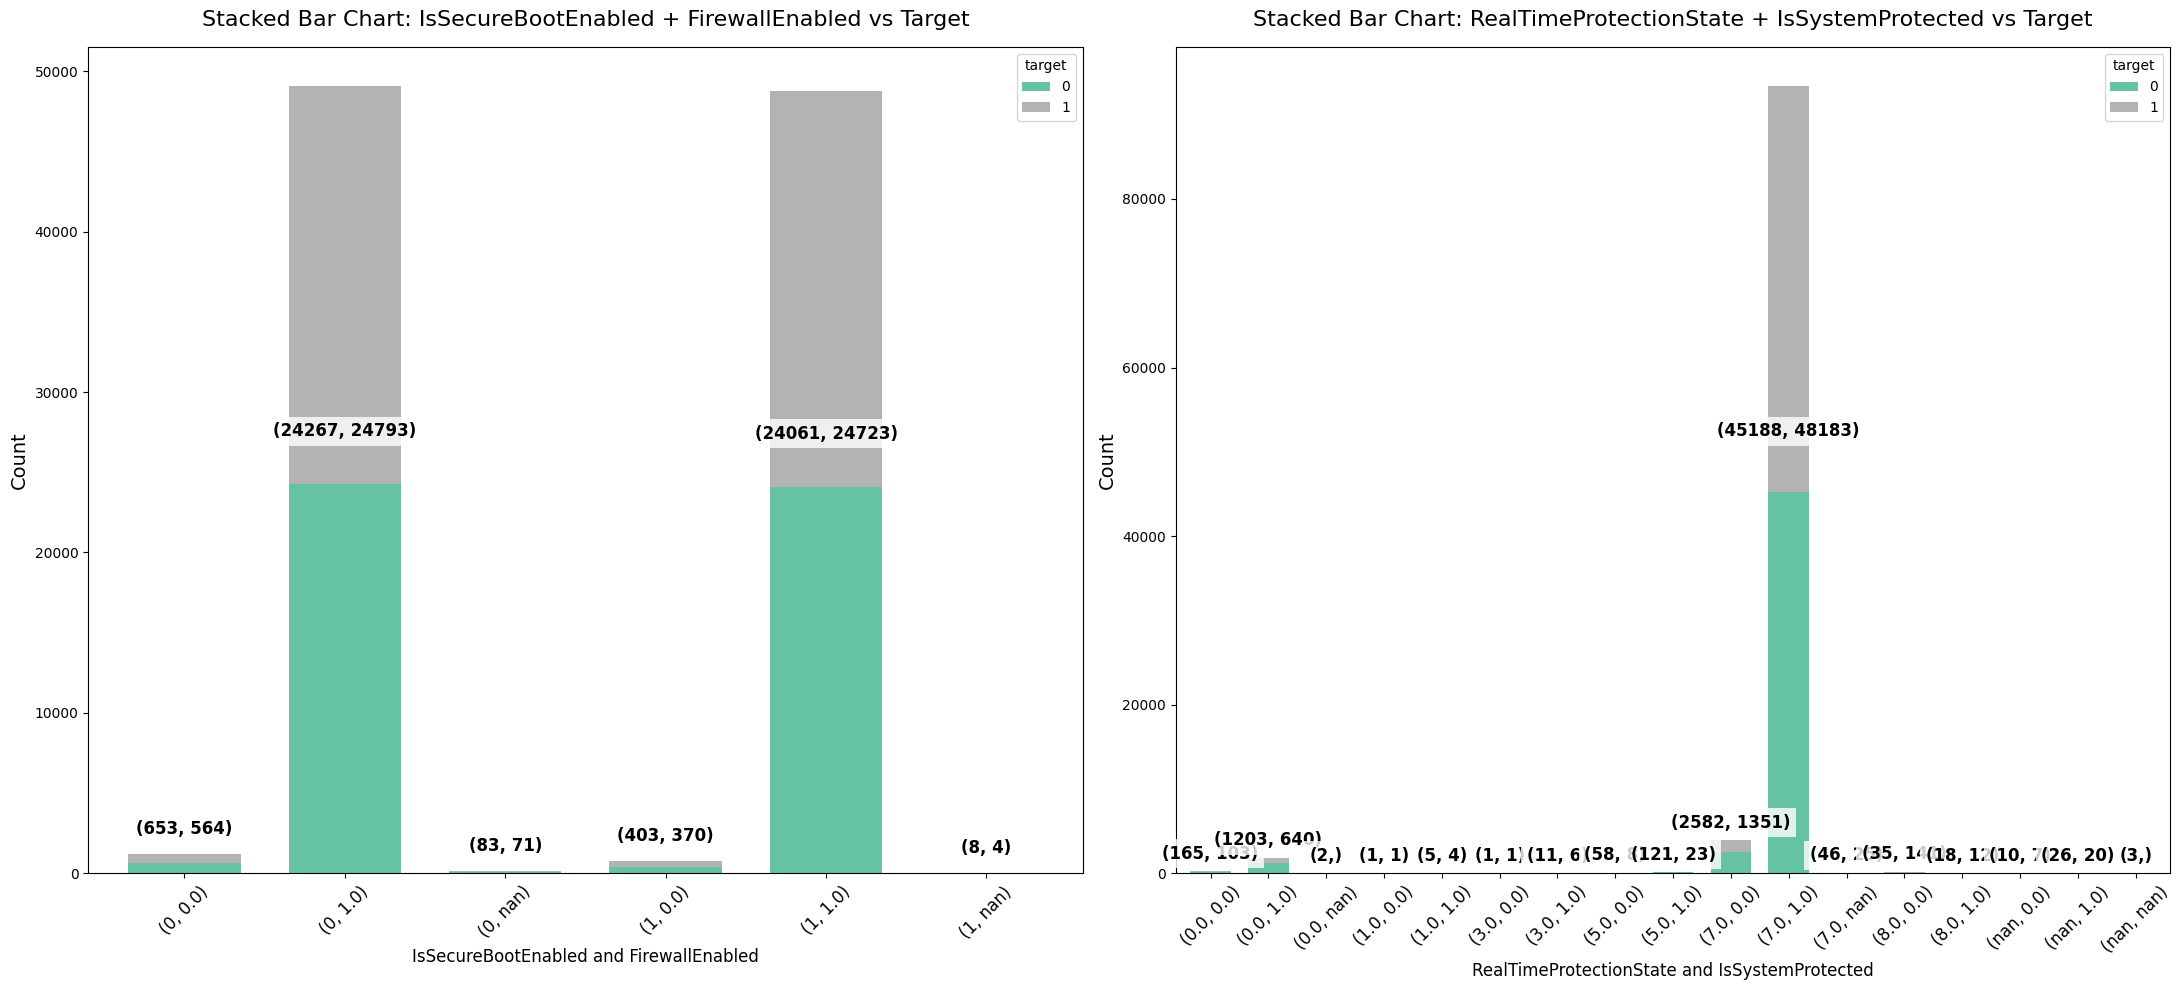

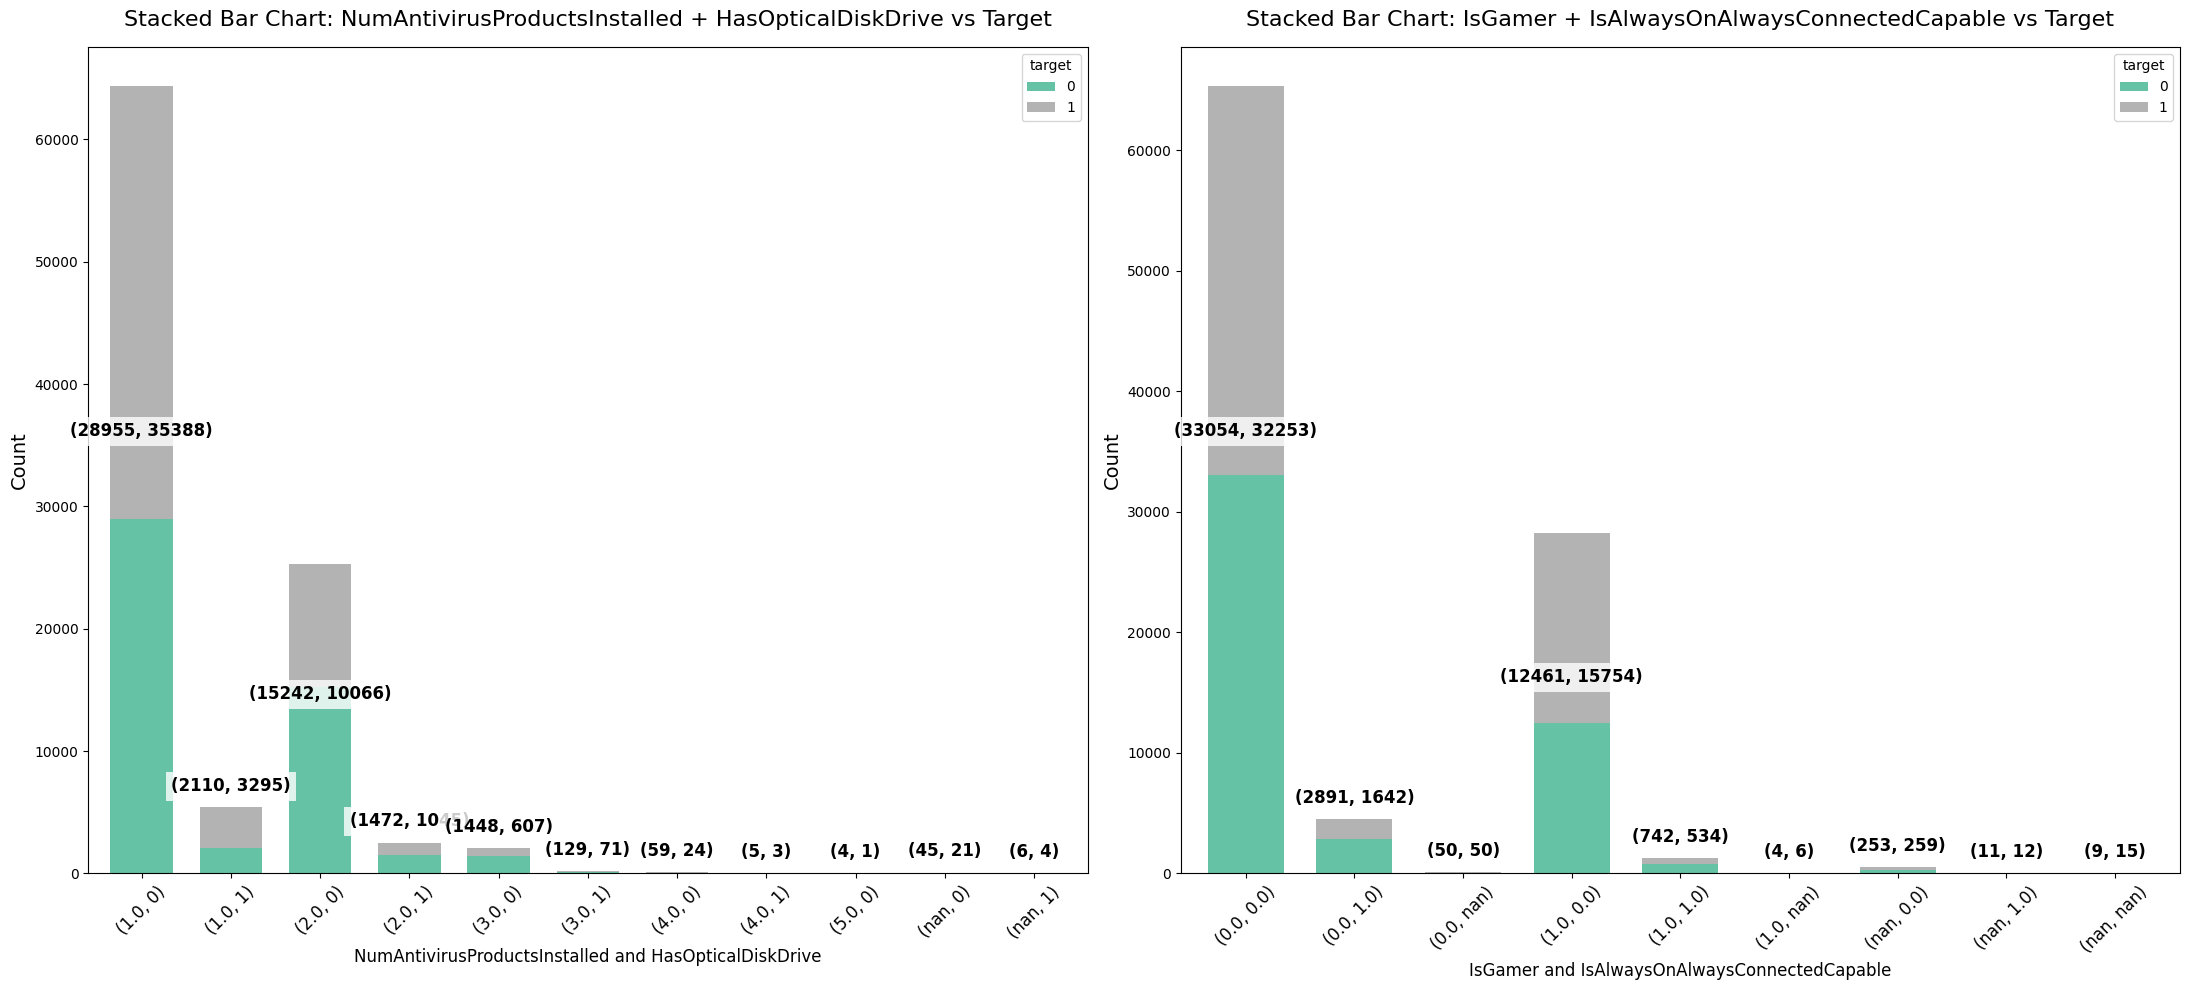

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define column pairs for stacked bar charts
column_pairs = [
    ("ProductName", "PlatformType"),
    ("Processor", "OSArchitecture"),
    ("IsSecureBootEnabled", "FirewallEnabled"),
    ("RealTimeProtectionState", "IsSystemProtected"),
    ("NumAntivirusProductsInstalled", "HasOpticalDiskDrive"),
    ("IsGamer", "IsAlwaysOnAlwaysConnectedCapable")
]

# Convert categorical variables to string
for col1, col2 in column_pairs:
    training_dataset[col1] = training_dataset[col1].astype(str)
    training_dataset[col2] = training_dataset[col2].astype(str)

# Use a visually appealing color scheme
colors = sns.color_palette("Set2")

# Process in batches of two charts at a time
batch_size = 2
for batch_start in range(0, len(column_pairs), batch_size):
    batch_pairs = column_pairs[batch_start:batch_start + batch_size]

    fig, axes = plt.subplots(1, batch_size, figsize=(22, 10))  # Two per row
    if batch_size == 1:
        axes = [axes]  # Ensure iterable when only one plot is created

    for i, (cat1, cat2) in enumerate(batch_pairs):
        if cat1 in training_dataset.columns and cat2 in training_dataset.columns and "target" in training_dataset.columns:
            grouped_data = training_dataset.groupby([cat1, cat2, "target"]).size().unstack().fillna(0)

            if not grouped_data.empty:
                ax = grouped_data.plot(kind="bar", stacked=True, ax=axes[i], colormap="Set2", width=0.7)

                axes[i].set_title(f"Stacked Bar Chart: {cat1} + {cat2} vs Target", fontsize=16, pad=15)
                axes[i].set_ylabel("Count", fontsize=14)
                axes[i].set_xlabel(f"{cat1} and {cat2}", fontsize=12)
                axes[i].tick_params(axis="x", rotation=45, labelsize=12)

                # Annotate bars with tuple values
                for idx in range(len(grouped_data)):
                    values = tuple(int(grouped_data.iloc[idx][col]) for col in grouped_data.columns if grouped_data.iloc[idx][col] > 0)
                    cumulative_height = sum(values)

                    # Adjust label position to avoid overlap
                    label_position = cumulative_height * 0.55 if cumulative_height > 8000 else cumulative_height + 1000

                    ax.text(idx, label_position, f"{values}", ha="center", va="bottom", fontsize=12, fontweight="bold",
                                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    plt.tight_layout()
    plt.show()  # Show and clear memory before the next batch


In [ ]:
'''Since win8defender + windows10 accounts for almost all cases, models might fail to generalize to other combinations.
Some rare categories may not contribute much to predictions.

x64 + amd64 systems are the most vulnerable, making them a security priority.
ARM architectures show minimal threats, suggesting lower risk for those systems.

Since threat levels remain similar, it suggests attackers may bypass firewall and Secure Boot protections.
These settings alone may not be effective for security.

Indicates that real-time protection alone is not enough to prevent threats.

More antivirus products do not necessarily mean more protection.
Optical drives do not contribute to security risks, so they may not be a useful predictive feature.

Gaming PCs are more likely to be always connected.
No clear trend showing gamers are more vulnerable.'''

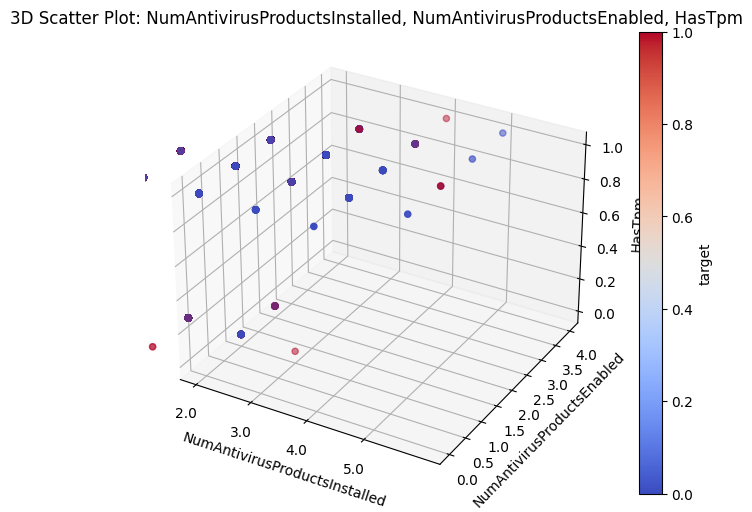

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(df, feature1, feature2, feature3, target):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    
    scatter = ax.scatter(df[feature1], df[feature2], df[feature3], c=df[target], cmap="coolwarm")
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(feature3)
    plt.colorbar(scatter, label=target)
    plt.title(f"3D Scatter Plot: {feature1}, {feature2}, {feature3}")
    plt.show()

plot_3d_scatter(training_dataset, "NumAntivirusProductsInstalled", "NumAntivirusProductsEnabled", "HasTpm", "target")


In [ ]:
'''Most points cluster near (1,1,1), indicating that most users have one antivirus installed, one enabled, and a TPM.
There is no clear separation between target classes, suggesting weak correlation between these features and threats.'''

In [5]:
training_dataset.drop(['MachineID'],axis=1,inplace=True)

In [7]:
training_dataset = training_dataset.drop(columns = ["OSArchitecture","FirewallEnabled","IsPassiveModeEnabled","IsSystemProtected","Processor","NumAntivirusProductsEnabled"])
training_dataset.shape

(100000, 69)

# Insights

In [39]:
unique_os_versions = training_dataset['OSVersion'].nunique()
print(unique_os_versions)

7


In [40]:
max_antivirus_installed = training_dataset['NumAntivirusProductsInstalled'].max()
print(max_antivirus_installed)

5.0


In [41]:
gamers_malware_detected = training_dataset[(training_dataset['IsGamer'] == 1) & (training_dataset['target'] == 1)].shape[0]
print(gamers_malware_detected)

16294


In [43]:
screen_resolution_count = training_dataset[(training_dataset['PrimaryDisplayResolutionHorizontal'] == 1366) & (training_dataset['PrimaryDisplayResolutionVertical'] == 768)].shape[0]
print(screen_resolution_count)

51435


In [44]:
median_ram = training_dataset['TotalPhysicalRAMMB'].median()
print(median_ram)

4096.0


In [45]:
avg_ram_malware = training_dataset[training_dataset['target'] == 1]['TotalPhysicalRAMMB'].mean()
print(avg_ram_malware)

6445.283499841421


In [47]:
processors_gt_4 = training_dataset[training_dataset['ProcessorCoreCount'] > 4].shape[0]
print(processors_gt_4)

11933


In [48]:
most_affected_country = training_dataset[training_dataset['target'] == 1]['CountryID'].mode()[0]
print(most_affected_country)

43


In [ ]:
'''The EDA reveals several crucial insights into the dataset, which can aid in predicting system threats effectively. 
Firstly, OS versions are limited to only seven distinct values, suggesting that this feature might be useful 
but not highly discriminative. Most systems have at most five antivirus products installed, but the number of 
enabled products remains low, indicating potential system vulnerabilities. Gamers appear to be more affected by 
malware, with 16,294 malware cases recorded, highlighting a potential risk group. Interestingly, 
Real-Time Protection (RTP) is mostly in a disabled state when Passive Mode is enabled, which could indicate that 
some security measures are being overridden. Additionally, a significant portion of systems (51,435 devices) have 
a common screen resolution of 1366x768, indicating a standard user base. Median RAM capacity is 4GB, but 
malware-affected systems tend to have an average of 6.4GB RAM, possibly suggesting high-end system usage is targeted. 
Moreover, over 11,933 devices have more than four processor cores, which might relate to system configurations more 
susceptible to malware. Country ID 43 is the most affected, which could indicate regional targeting of threats. 
On a feature selection note, fields such as OS Architecture, Passive Mode, Firewall Enabled, and Optical Disk Drive 
are highly imbalanced, making them potential candidates for removal or transformation. 
Overall, the findings indicate that antivirus configurations, system specifications, and geographic factors play a 
significant role in system vulnerability, forming the backbone for an effective threat forecasting model.'''

# Feature Extraction

In [26]:
def extract_features(X_train, X_test):
    unique_counts = X_train.nunique()
    redundant_cols = unique_counts[unique_counts == 1].index.tolist()
    
    correlation_matrix = X_train.corr()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    highly_correlated_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
    
    low_variance_threshold = 0.02  
    low_variance_cols = X_train.var()[X_train.var() < low_variance_threshold].index.tolist()
    
    skew_threshold = 2 
    skewed_cols = X_train.skew()[np.abs(X_train.skew()) > skew_threshold].index.tolist()
    
    features_to_remove = list(set(redundant_cols + highly_correlated_cols + low_variance_cols))
    
    X_train.drop(columns=features_to_remove, inplace=True, errors='ignore')
    X_test.drop(columns=features_to_remove, inplace=True, errors='ignore')
    
    return X_train, X_test


# Encoding

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def encode_categorical_features(X_train, X_test, high_cardinality_threshold=10):
    categorical_cols = X_train.select_dtypes(include=['object']).columns
    low_cardinality_cols = [col for col in categorical_cols if X_train[col].nunique() <= high_cardinality_threshold]
    high_cardinality_cols = [col for col in categorical_cols if X_train[col].nunique() > high_cardinality_threshold]

    # One-Hot Encoding for Low Cardinality Categorical Features
    if low_cardinality_cols:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[low_cardinality_cols]))
        X_test_ohe = pd.DataFrame(ohe.transform(X_test[low_cardinality_cols]))

        # Restore column names
        X_train_ohe.columns = ohe.get_feature_names_out(low_cardinality_cols)
        X_test_ohe.columns = ohe.get_feature_names_out(low_cardinality_cols)

        # Reset index to align with original DataFrame
        X_train_ohe.index = X_train.index
        X_test_ohe.index = X_test.index

        # Drop original columns and concatenate encoded features
        X_train = X_train.drop(columns=low_cardinality_cols).reset_index(drop=True)
        X_test = X_test.drop(columns=low_cardinality_cols).reset_index(drop=True)

        X_train = pd.concat([X_train, X_train_ohe], axis=1)
        X_test = pd.concat([X_test, X_test_ohe], axis=1)

    # Frequency Encoding for High Cardinality Features
    for col in high_cardinality_cols:
        freq_encoding = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq_encoding)
        X_test[col] = X_test[col].map(freq_encoding).fillna(0)  # Handle unknown categories in test data

    return X_train, X_test

# Handling Missing Values

In [22]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression

def handle_missing_values(X_train):
    numeric_cols = X_train.select_dtypes(include=['number']).columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns
    
    # Step 1: KNN Imputation for Numerical Data (Only if missing values are low)
    knn_imputer = KNNImputer(n_neighbors=5)
    knn_imputed_data = knn_imputer.fit_transform(X_train[numeric_cols])
    X_train[numeric_cols] = knn_imputed_data
    
    # Step 2: Median Imputation for Highly Skewed Numeric Data
    median_imputer = SimpleImputer(strategy='median')
    X_train[numeric_cols] = median_imputer.fit_transform(X_train[numeric_cols])
    
    # Step 3: Regression-Based Imputation for Selected Features
    for col in numeric_cols:
        if X_train[col].isnull().sum() > 0:
            known = X_train[X_train[col].notnull()]
            unknown = X_train[X_train[col].isnull()]
            
            if not known.empty and not unknown.empty:
                predictors = [c for c in numeric_cols if c != col]  # Use other numerical columns as features
                model = LinearRegression()
                model.fit(known[predictors], known[col])
                X_train.loc[X_train[col].isnull(), col] = model.predict(unknown[predictors])
    
    # Step 4: Grouped Mode Imputation for Categorical Data
    for col in categorical_cols:
        if X_train[col].isnull().sum() > 0:
            # Fill NaNs with mode within each group (e.g., PlatformType if available)
            if 'PlatformType' in X_train.columns:
                X_train[col] = X_train.groupby('PlatformType')[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))
            else:
                X_train[col].fillna(X_train[col].mode()[0], inplace=True)  # Regular mode if no grouping feature available

    return X_train

# Scaling

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

def scale_features(X_train, X_test):
    numerical_cols = X_train.select_dtypes(include=['number']).columns

    # Identify features with high skewness for special treatment
    skewed_features = X_train[numerical_cols].apply(lambda x: x.skew()).abs()
    highly_skewed = skewed_features[skewed_features > 1].index.tolist()
    
    # Standard Scaling (Default)
    standard_scaler = StandardScaler()
    X_train[numerical_cols] = standard_scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = standard_scaler.transform(X_test[numerical_cols])
    
    # Min-Max Scaling for features with bounded values (e.g., percentages)
    minmax_scaler = MinMaxScaler()
    X_train[highly_skewed] = minmax_scaler.fit_transform(X_train[highly_skewed])
    X_test[highly_skewed] = minmax_scaler.transform(X_test[highly_skewed])

    # Robust Scaling for outlier-heavy features
    robust_scaler = RobustScaler()
    X_train[highly_skewed] = robust_scaler.fit_transform(X_train[highly_skewed])
    X_test[highly_skewed] = robust_scaler.transform(X_test[highly_skewed])

    # Power Transformation for highly skewed features
    power_transformer = PowerTransformer(method='yeo-johnson')
    X_train[highly_skewed] = power_transformer.fit_transform(X_train[highly_skewed])
    X_test[highly_skewed] = power_transformer.transform(X_test[highly_skewed])

    return X_train, X_test

# Pipeline Execution

In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer

In [99]:
def preprocess_data(train_df, test_df):
    train_df = train_df.dropna(subset=['target'])
    train_df['target'] = train_df['target'].astype(int)
    
    X_train = train_df.drop(columns=['target'], errors='ignore')
    y_train = train_df['target']
    X_test = test_df.copy()
    
    X_train = handle_missing_values(X_train)
    X_train, X_test = encode_categorical_features(X_train, X_test)
    X_train, X_test = extract_features(X_train, X_test)
    X_train, X_test = scale_features(X_train, X_test)
    
    return X_train, y_train.to_numpy(), X_test

In [100]:
df = load_dataset()
train_df, test_df, submission_df = load_data(df, "/kaggle/input/System-Threat-Forecaster/test.csv", "/kaggle/input/System-Threat-Forecaster/sample_submission.csv")
X_train, y_train, X_test = preprocess_data(train_df, test_df)
print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training Data Shape: (100000, 72)
Test Data Shape: (10000, 72)


# ML Models

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [102]:
def select_features(X_train, y_train, model_type):

    selected_features = []

    # Drop Highly Correlated Features (correlation > 0.95)
    corr_matrix = X_train.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
    X_train.drop(columns=high_corr_features, inplace=True)

    # Model-Specific Feature Selection
    if model_type in ["logistic_regression", "svc"]:
        lasso = LassoCV(cv=5).fit(X_train, y_train)
        selected_features = X_train.columns[np.abs(lasso.coef_) > 0.01].tolist()

    elif model_type in ["random_forest", "xgboost", "lightgbm", "decision_tree"]:
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
        importances = model.feature_importances_
        selected_features = X_train.columns[importances > np.percentile(importances, 25)].tolist()  # Top 75% features

    elif model_type in ["knn", "naive_bayes"]:
        kbest = SelectKBest(score_func=f_classif, k=20)
        kbest.fit(X_train, y_train)
        selected_features = X_train.columns[kbest.get_support()].tolist()

    elif model_type in ["pca_based"]:
        pca = PCA(n_components=20)
        X_train_pca = pca.fit_transform(X_train)
        selected_features = X_train.columns[:20]

    return X_train[selected_features], selected_features

In [103]:
def train_models(X_train, y_train, X_val, y_val):
    """
    Trains multiple models and returns accuracy & F1 score.
    """
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(),
        "KNN": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier()
    }

    baseline_results = {}

    for name, model in models.items():
        model_type = name.lower().replace(" ", "_")
        X_train_selected, selected_features = select_features(X_train, y_train, model_type)

        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_val[selected_features])

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        print(f"📌 {name} - Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")
        baseline_results[name] = {"model": model, "accuracy": acc, "f1_score": f1, "features": selected_features}

    return baseline_results

# HyperTuning

In [104]:
def tune_models(X_train, y_train, X_val, y_val, baseline_results):
    """
    Performs hyperparameter tuning for selected models.
    """
    param_grids = {
        "Logistic Regression": {'C': [0.01, 0.1, 1, 10]},
        "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, None]},
        "XGBoost": {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9]},
        "KNN": {'n_neighbors': [3, 5, 7, 9]},
        "Naive Bayes": {'var_smoothing': np.logspace(-9, 0, 10)},
        "Decision Tree": {'max_depth': [3, 5, 10, 20]}
    }

    tuned_results = {}

    for name, model_info in baseline_results.items():
        if name in param_grids:
            model = model_info["model"]
            selected_features = model_info["features"]

            grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='f1_macro', n_jobs=-1)
            grid_search.fit(X_train[selected_features], y_train)

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_val[selected_features])

            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='macro')

            print(f"✅ {name} (Tuned) - Best Params: {grid_search.best_params_}, Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")
            tuned_results[name] = {"model": best_model, "accuracy": acc, "f1_score": f1}

    return tuned_results

# Comparing ML models

In [105]:
def plot_model_comparison(baseline, tuned):
    models = list(baseline.keys())
    x = np.arange(len(models))
    width = 0.3  # Width of bars

    baseline_scores = [baseline[m]["f1_score"] for m in models]
    tuned_scores = [tuned[m]["f1_score"] for m in models]

    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='gray', alpha=0.8)
    bars2 = ax.bar(x + width/2, tuned_scores, width, label='Tuned', color='green', alpha=0.8)

    ax.set_xlabel("Models", fontsize=12)
    ax.set_ylabel("Macro F1 Score", fontsize=12)
    ax.set_title("Model Comparison: Baseline vs Hyperparameter Tuning", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=25, ha="right", fontsize=10)

    # Move legend to avoid overlapping
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, frameon=False)

    # Add labels with precise values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Adjust position slightly above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.tight_layout()  # Ensures better spacing
    plt.show()


📌 Logistic Regression - Accuracy: 0.5972, Macro F1: 0.5957
📌 Random Forest - Accuracy: 0.6054, Macro F1: 0.6052
📌 XGBoost - Accuracy: 0.6152, Macro F1: 0.6142
📌 KNN - Accuracy: 0.5604, Macro F1: 0.5598
📌 Naive Bayes - Accuracy: 0.5738, Macro F1: 0.5561
📌 Decision Tree - Accuracy: 0.5434, Macro F1: 0.5434
✅ Logistic Regression (Tuned) - Best Params: {'C': 0.1}, Accuracy: 0.5972, Macro F1: 0.5957


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Random Forest (Tuned) - Best Params: {'max_depth': 20, 'n_estimators': 200}, Accuracy: 0.6190, Macro F1: 0.6174
✅ XGBoost (Tuned) - Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}, Accuracy: 0.6191, Macro F1: 0.6176
✅ KNN (Tuned) - Best Params: {'n_neighbors': 9}, Accuracy: 0.5752, Macro F1: 0.5746
✅ Naive Bayes (Tuned) - Best Params: {'var_smoothing': 1e-09}, Accuracy: 0.5738, Macro F1: 0.5561
✅ Decision Tree (Tuned) - Best Params: {'max_depth': 5}, Accuracy: 0.5955, Macro F1: 0.5912


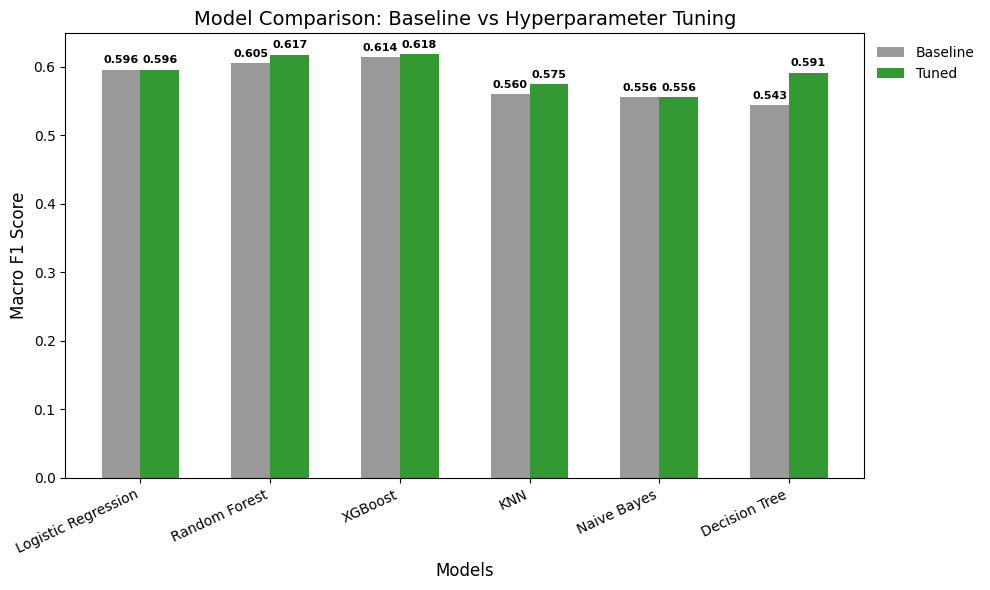


🏆 Best Model Selected: XGBoost


In [106]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# baseline_results = train_models(X_train, y_train, X_val, y_val)
# tuned_results = tune_models(X_train, y_train, X_val, y_val, baseline_results)
# plot_model_comparison(baseline_results, tuned_results)
# best_model_name = max(tuned_results, key=lambda k: tuned_results[k]["f1_score"])
# best_model = tuned_results[best_model_name]["model"]
# print(f"\n🏆 Best Model Selected: {best_model_name}")

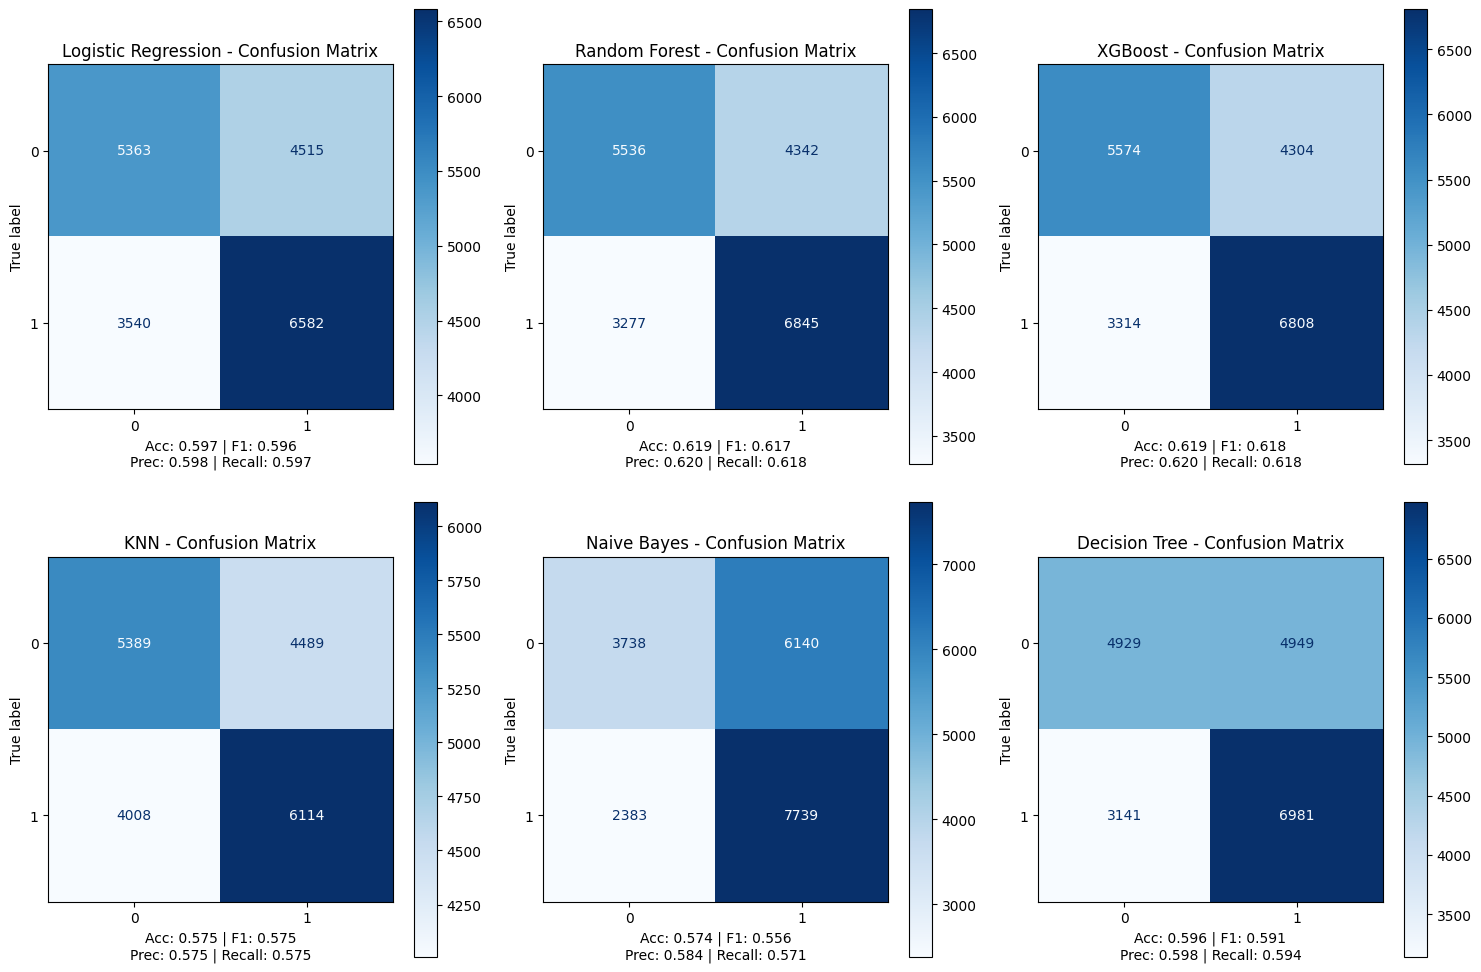

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

models_per_row = 3
num_models = len(tuned_results)
rows = (num_models // models_per_row) + (num_models % models_per_row > 0)
fig, axes = plt.subplots(rows, models_per_row, figsize=(15, 5 * rows))

if rows == 1:
    axes = [axes]

for idx, (name, model_info) in enumerate(tuned_results.items()):
    row, col = divmod(idx, models_per_row)
    ax = axes[row][col] if rows > 1 else axes[col]  # Handle different row cases
    
    model = model_info["model"]
    selected_features = baseline_results[name]["features"]
    X_val_selected = X_val[selected_features]

    y_pred = model.predict(X_val_selected)
    cm = confusion_matrix(y_val, y_pred)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=0)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues")
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel(f"Acc: {acc:.3f} | F1: {f1:.3f}\nPrec: {precision:.3f} | Recall: {recall:.3f}")

plt.tight_layout()
plt.show()


In [107]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define parameter grid for tuning
xgb_params = {
    "n_estimators": [150, 250, 350],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.75, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# Initialize and train using hyperparameter tuning
xgb_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=xgb_params, n_iter=10, cv=3, scoring='accuracy', random_state=42
)

xgb_search.fit(X_train, y_train)

# Retrieve best model
best_xgb = xgb_search.best_estimator_
print("\n✅ Best XGBoost Parameters:", xgb_search.best_params_)

# Evaluate the optimized model
y_pred_train = best_xgb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("\n✅ Optimized XGBoost Accuracy on Train Data:", train_accuracy)



✅ Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

✅ Optimized XGBoost Accuracy on Train Data: 0.680725


In [108]:
# Predict on test dataset
predictions_test = best_xgb.predict(X_test)
submission_df['target'] = predictions_test  # Assign predictions to 'target' column
submission_df.to_csv("/kaggle/working/submission.csv", index=False)

print("\n✅ Submission file created successfully at /kaggle/working/submission.csv!")


✅ Submission file created successfully at /kaggle/working/submission.csv!
